## City Logistics Analysis ##

### Introduction ###

When it comes to automate an logistics pipeline, depending on the scale or the alogoritm being used, it's not always possible to request from google the time to go from a point to another for every pair of points. In this cases, an aproximation might be better suited. This analysis is the tool to get to this aproximation.

### What will be done ###

Loren ipsun

### Let's beggin! ###

In [124]:
#Data visualization
import matplotlib.pyplot as plt
import folium

#Data cleaning and modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np

#Google API
from googleplaces import GooglePlaces
import googlemaps

#Support functions
from time import sleep
from shapely.geometry import Point
import yaml

#No warnings
import warnings
warnings.filterwarnings("ignore")

#Open the config file
config = yaml.safe_load(open("config.yml"))

### Randon samples

The first step is to get a random sample of pairs of addresses from the desired location. For this, the Google Nearby Search API will be used.

In [85]:
#Setup. It's all defined on the config.yml document

# Set our Google API Key and connect into google maps
google_places = GooglePlaces(config['google_api_key'])
gmaps = googlemaps.Client(key=config['google_api_key'])
#Some configurations
city = config['city']
lat = config['lat']
lng = config['lng']

In [33]:
#Making the request
query_result = google_places.text_search(
        query='Markets in {city}'.format(city=city))

#Dumping into a list
results = list()
for place in query_result.places:
    aux_dict = {'lat': place.geo_location['lat'],
                'lng': place.geo_location['lng'],
                'name': place.name}

    results.append(aux_dict)

#If there are more results, keep querying. It's set to query 5 times, for a maximum of 100 locations
for i in range(5):
    if (query_result.has_next_page_token):
        sleep(3)
        query_result = google_places.text_search(
            pagetoken=query_result.next_page_token)
        
        for place in query_result.places:
            aux_dict = {'lat': place.geo_location['lat'],
                        'lng': place.geo_location['lng'],
                        'name': place.name}
                        
            results.append(aux_dict)


The number of possible pairs is (n*n-1)/2:

In [34]:
print("Number of locations: ", len(results))
print("Possible pairs: ", len(results)*(len(results)-1)/2)

Number of locations:  60
Possible pairs:  1770.0


Ploting the locations on a map, so we can better vizualize what are we working with. The locations are not random, they are ranked by Google. Depending on the subject of study, it might be necessary to modify the quer to get more heterogeneous data.

In [35]:
region_map = folium.Map(location=[lat, lng], zoom_start=12)

for i in results:
    folium.Marker([i['lat'], i['lng']]).add_to(region_map)

region_map

Now we will pair the locations. 

In [78]:
pairs = list()

#For every location, iterr with the remaining locations
for i in range(len(results)):
    for j in range(i+1, len(results)):
        point1 = Point(results[i]['lat'], results[i]['lng'])
        point2 = Point(results[j]['lat'], results[j]['lng'])
        #Distance between the points, in km
        straight_distance = point1.distance(point2) * 111.32

        aux_dict = {'point1': point1,
                    'point2': point2,
                     'straight_distance': straight_distance}

        pairs.append(aux_dict)   

#Turning into a dataframe
pairs = pd.DataFrame(data=pairs)

The data might need to be cleaned to ensure there is no points autside the city. First, a histogram will be ploted with the distribution of distances (in km) on the x axis, so we can se if there is the case.

<AxesSubplot:>

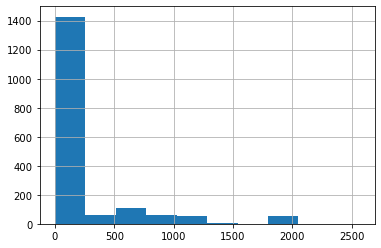

In [79]:
pairs['straight_distance'].hist()

Now cleaning it. We will discart every pair with a distance greater than 50km

In [80]:
pairs = pairs[pairs['straight_distance'] < 50]

Let's check again

<AxesSubplot:>

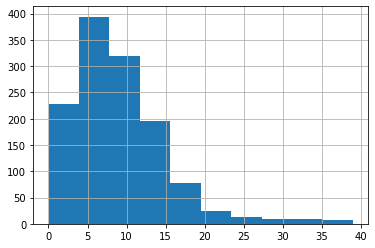

In [81]:
pairs['straight_distance'].hist()

Much better.

Now, the number of pairs might be unnecessarily big, costing when using the Distance Matrix API. So we will get a random sample within our sample, of 300 pairs.

In [83]:
print("There were {}. We will use only 300 of those.".format(len(pairs)))
sub_sample = pairs.sample(n=300)

There were 1276. We will use only 300 of those.


It's time to get the real distance and time of the journey. For each pair, we will use the Distance Matrix API to get the predicted travel from Google Maps.

In [110]:
#Suport lists
distance_maps = list()
travel_time = list()

#For every pair, we will get the travel distance and travel time
for i, pair in sub_sample.iterrows():
    
    route = gmaps.distance_matrix((pair['point1'].x, pair['point1'].y), (pair['point2'].x, pair['point2'].y), mode='driving')

    #Append to temporary lists
    distance_maps.append(route['rows'][0]["elements"][0]['distance']['value'])
    travel_time.append(route['rows'][0]["elements"][0]['duration']['value'])

#Add the data to the DataFrame
sub_sample['distance_maps'] = distance_maps
sub_sample['travel_time'] = travel_time


Now a little bit of data cleaning

In [112]:
#Distance from meters to kilometers
sub_sample['distance_maps'] = sub_sample['distance_maps']/1000
#Time from seconds to minutes
sub_sample['travel_time'] = sub_sample['travel_time']/60

With the data scrapping and cleaning done, it's time to look at the data and find out Ipsum Loren

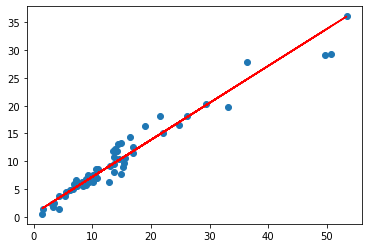

0.946032901982546


In [132]:
X = np.array(sub_sample['distance_maps']).reshape(-1, 1)
y = np.array(sub_sample['straight_distance']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color ='red')
  
plt.show()
print(regressor.score(X_test, y_test))

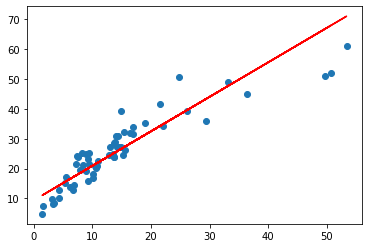

0.8015687362701525


In [145]:
X = np.array(sub_sample['distance_maps']).reshape(-1, 1)
y = np.array(sub_sample['travel_time']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color ='red')
  
plt.show()
print(regressor.score(X_test, y_test))

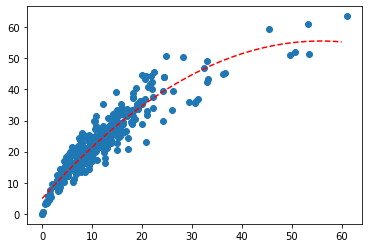

In [173]:
def objective(x, a, b, c):
	return (a * x) + (b * x**2) + c

x = sub_sample['distance_maps']
y = sub_sample['travel_time']

popt, _ = curve_fit(objective, x, y)

a, b, c = popt
# plot input vs output
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
plt.show()

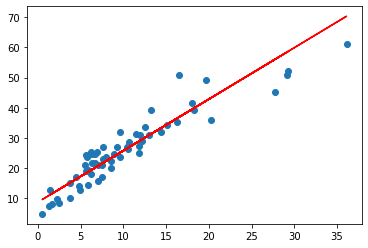

0.8566931657000775


In [134]:
X = np.array(sub_sample['straight_distance']).reshape(-1, 1)
y = np.array(sub_sample['travel_time']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color ='red')
  
plt.show()
print(regressor.score(X_test, y_test))